In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Path: data_exploration.ipynb
# Load the dataset rotten_tomatoes_movies.csv in Data folder
df = pd.read_csv("Data/RT/rotten_tomatoes_movies.csv")

# Replace empty strings with NaN
df.replace("", pd.NA, inplace=True)

# Count the number of NaN values in each column
null_counts = df.isna().sum()

# give a percentage of NaN values in each column
null_counts_percent = null_counts / len(df) * 100

# Display the count of NaN values per column
print(null_counts)
print(null_counts_percent)


#create a dataframe that has only the titles for english movies (based on the language column)
df_english = df[df.originalLanguage == "English"]

# Display the first 5 rows of the dataframe
df_english.head()

# Display the number of rows and columns in the dataframe
df_english.shape

#sort the dataframe by the year column

# add a new coloumn called year and extract the year from the release date column that looks like this format: 2018-08-25
df_english["year"] = df_english.releaseDateStreaming.str[:4]

# sort the dataframe by the year column in descending order
df_english.sort_values(by="year", ascending=False, inplace=True)

# remove the null values in the year column
df_english = df_english[df_english.year.notnull()]

# remove the values that older then 2000
df_english = df_english[df_english.year.astype(int) >= 2000]

# dump the dataframe to a csv file
df_english.to_csv("Data/RT/rotten_tomatoes_movies_english_names.csv", index=False)

# give me a list of all the movie titles that are in the dataframe
df_english.title.tolist()

# store it in a text file
with open("Data/Final/rotten_tomatoes_movies_english_title.txt", "w") as f:
    # if its a flaot print it as a float, otherwise print it as a string
    for item in df_english.title.tolist():
        if isinstance(item, float):
            f.write(f"{item}\n")
        else:
            f.write(f"{item}\n")
            




In [ ]:
# lets try this: https://rotten-tomatoes-api.ue.r.appspot.com/movie/bad_boys 
# !pip3 install requests

import requests
import json
import pandas as pd
import time

movies = []

#open the text file and read it line by line and store it in a list for the first 100 movies
with open("Data/Final/rotten_tomatoes_movies_english_title.txt", "r") as f:
    movies = [line.strip() for line in f.readlines()][4300:4400]
f.close()


#loop through the list and make each of them lowercase and also replace space in between words with _
movies = [movie.lower().replace(" ", "_") for movie in movies]


print(movies)

# Create an empty list to store movie data
movie_data = []

# Loop through each movie title
for movie in movies:

    print(f"Scraping {movie}")
    # Create the API url
    url = f'https://rotten-tomatoes-api.ue.r.appspot.com/movie/{movie}'

    # sleep for 1 secs
    time.sleep(1)

    # Make a GET request to the API
    response = requests.get(url)

    print(response.text)

    # if it returns {"detail":"Not Found"} then skip it or if it says "Internal Server Error" then skip it
    if response.text == '{"detail":"Not Found"}' or response.text == "Internal Server Error":
        continue

    # Convert the response JSON into a Python dictionary
    data = json.loads(response.text)

    # print movie hAS BEEN APPENDED
    print(f"{movie} has been appended")

    # Append the movie data to the list
    movie_data.append(data)

# Create a dataframe from the list of dictionaries
df = pd.DataFrame(movie_data)

# Display the dataframe
df.head()

#append in a csv file if it doesnt exist
df.to_csv("Data/Final/4k-5k.csv", mode="a", header=False)

In [ ]:
# Load the dataset output_with_movie_data.csv in Data folder
df = pd.read_csv("Data/Final/output_with_movie_data_NAN.csv")

# Replace 0's with NaN
df.replace(0, pd.NA, inplace=True)

# Count the number of NaN values in each column
null_counts = df.isna().sum()

# give a percentage of NaN values in each column
null_counts_percent = null_counts / len(df) * 100

# Display the count of NaN values per column
print(null_counts)

# Display the count of NaN values per column
print(null_counts_percent)

In [ ]:

start_movie_index = 8000  # Modify this as needed
end_movie_index = 10000  # Modify this as needed

checkpoint_interval = 100
checkpoint_folder = "Data/Final/Checkpoints"
# Function to load movies from file
def load_movies(filepath, start_index, end_index):
    with open(filepath, "r") as f:
        movies = [line.strip() for line in f.readlines()][start_index:end_index]
    return movies

movies = load_movies("Data/Final/rotten_tomatoes_movies_english_title.txt", start_movie_index, end_movie_index)
movies = [movie.lower().replace(" ", "_") for movie in movies]

movie_data = []
pbar = tqdm(total=end_movie_index-start_movie_index, desc="Scraping movies", unit="movie")

# Loop through each movie title
for i, movie in enumerate(movies, start=start_movie_index):
    try:
        url = f'https://rotten-tomatoes-api.ue.r.appspot.com/movie/{movie}'
        time.sleep(1)
        response = requests.get(url)
        if response.text == '{"detail":"Not Found"}' or "Internal Server Error" in response.text:
            pbar.update(1)
            continue
        data = json.loads(response.text)
        movie_data.append(data)
        if (i+1) % checkpoint_interval == 0 or i+1 == end_movie_index:
            checkpoint_filename = f"movies_{i+1-checkpoint_interval}-{i+1}.csv"
            save_to_csv(movie_data, checkpoint_folder, checkpoint_filename)
            movie_data = []  
    except Exception as e:
        print(f"An error occurred while scraping {movie}: {e}")
        continue 
    finally:
        pbar.update(1)

if movie_data:
    checkpoint_filename = f"movies_{end_movie_index-len(movie_data)+1}-{end_movie_index}.csv"
    save_to_csv(movie_data, checkpoint_folder, checkpoint_filename)

pbar.close()
print("Scraping complete. Data saved.")


In [3]:
# ?Merging files inside Checkpoints folder into one file called output_movies_data_4k-10k.csv
# Also keep in mind that the first file in the folder will have the header, so we need to remove the header from the rest of the files

import pandas as pd
import os

# Define the folder to store checkpoint files
checkpoint_folder = "Data/Final/Output/ChunkedData"

# Get all the files in the folder
files = os.listdir(checkpoint_folder)

# Sort the files by name
files.sort()

# Create an empty list to store the dataframes
dfs = []

# Loop through each file
for file in files:
    # Skip the file if it's not a CSV file
    if not file.endswith(".csv"):
        continue

    # Read the CSV file
    df = pd.read_csv(os.path.join(checkpoint_folder, file))

    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all the dataframes into one
df = pd.concat(dfs)

# Save the dataframe to a CSV file
df.to_csv("Data/Final/output_movies_data_0-45k.csv", index=False)




In [ ]:

#open the file again and add the firest column as index
df = pd.read_csv("Data/Final/output_movies_data_4k-35k.csv", index_col=0)

# append a index column to the start of the dataframe concat
df.reset_index(inplace=True)


# Display the dataframe
df.head()

#save the dataframe to a csv file
df.to_csv("Data/Final/output_movies_data_4k-35k.csv", index=False)

In [3]:
from collections import defaultdict
import csv
# namesDict contains the names mapped to a tuple where other scores are set to zero
namesDict = defaultdict(tuple)

def findMax(lst):
    lst = [float(i) for i in lst]
    # set all values to zero exept the max value
    maxVal = max(lst)
    lst = [1 if i == maxVal else 0 for i in lst]
    return tuple(lst)

# open file and load movies into dictionary
datafile = "Data/Final/Ethnicity/cast_ethnicity.csv"
with open(datafile, "r", encoding="utf-8") as file:
    reader = csv.reader(file, delimiter=',')
    header = next(reader)
    for row in reader:
        namesDict[row[0]] = findMax(row[2:])

print(namesDict['Jim Parsons'])
print(namesDict['Danny Pudi'])
print(namesDict['Ashley Nicole Williams'])

# for these actors ['Ray Danton', 'Karen Steele', 'Elaine Stewart', 'Jesse White', 'Simon Oakland']  in namesDict, find the diversity score where each value in the tuple is the diversity score in this order 2PRACE,Hispanic,API,Black,AIAN,White;


(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)


In [9]:
newdf = pd.read_csv("final_merged_Numbers.csv")

# sort it by the year column
newdf.sort_values(by="year", ascending=False, inplace=True)


# remove all the movies that are older then 2000
newdf = newdf[newdf.year.astype(int) >= 2000]

#drop all duplicates based on name
newdf.drop_duplicates(subset="name", keep="first", inplace=True)


#Only keep rows with 5 entires in the actors column
newdf = newdf[newdf.actors.str.count(",") == 4]


# Save it to a csv file with the year column
newdf.to_csv("Numbers_by_year_2000+.csv", index=False)



In [6]:
def calculate_diversity_score(data):
    # Sum the scores for each ethnicity
    sums = [sum(category) for category in zip(*data.values())]
    total = sum(sums)
    
    # Calculate the proportions and their squares
    proportions = [s / total for s in sums]
    squared_proportions = [p**2 for p in proportions]
    
    # Calculate Gini impurity
    gini_impurity = sum(squared_proportions)
    
    # Calculate the diversity score as 1 - Gini impurity
    diversity_score = 1 - gini_impurity 
    return diversity_score

# Dictionary for actor scores
"['Michelle Yeoh', 'Stephanie Hsu', 'Ke Huy Quan', 'James Hong', 'Jamie Lee Curtis']"

# Test 1, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.9995
# Test 2, 0.0001, 0.0001, 0.0001, 0.0001, 0.9995, 0.0001
# Test 3, 0.0001, 0.0001, 0.0001, 0.9995, 0.0001, 0.0001
# Test 4, 0.0001, 0.0001, 0.9995, 0.0001, 0.0001, 0.0001
# Test 5, 0.0001, 0.9995, 0.0001, 0.0001, 0.0001, 0.0001
# Test 6, 0.9995, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001  

# actor_scores = {
#     'Michelle Yeoh': namesDict['Michelle Yeoh'],
#     'Stephanie Hsu': namesDict['Stephanie Hsu'],
#     'Ke Huy Quan': namesDict['Ke Huy Quan'],
#     'James Hong': namesDict['James Hong'],
#     'Jamie Lee Curtis': namesDict['Jamie Lee Curtis']
# }

# print(namesDict['Michelle Yeoh'])
# print(namesDict['Stephanie Hsu'])
# print(namesDict['Ke Huy Quan'])
# print(namesDict['James Hong'])
# print(namesDict['Jamie Lee Curtis'])
actor_scores = {
    'Test 1': namesDict['Test 1'],
    'Test 2': namesDict['Test 2'],
    'Test 3': namesDict['Test 3'],
    'Test 4': namesDict['Test 4'],
    'Test 5': namesDict['Test 5']
}

# Calculate the movie's diversity score
movie_diversity_score = calculate_diversity_score(actor_scores)
print("The movie's diversity score is:", movie_diversity_score)

The movie's diversity score is: 1


In [7]:
# MODIFIED GINI

def calculate_diversity_score(data):
    # Calculate the average probability for each ethnicity across all actors
    average_probabilities = [sum(category) / len(data) for category in zip(*data.values())]
    
    # Calculate the total squared deviation from the average for each ethnicity across all actors
    total_squared_deviation = sum(
        (actor_probs[i] - avg_prob) ** 2
        for i, avg_prob in enumerate(average_probabilities)
        for actor_probs in data.values()
    )
    
    # The maximum squared deviation for any actor would be if they had a probability of 1 for an ethnicity,
    # and the average probability would be 1/number of actors for that ethnicity
    max_deviation = sum((1 - (1 / len(data))) ** 2 for _ in average_probabilities)

    # Normalize the total squared deviation to get the diversity score
    diversity_score = 1 - (total_squared_deviation / max_deviation)
    return diversity_score


# The namesDict should contain actual data for each actor's ethnicity
actor_scores = {
    'Test 1': namesDict['Test 1'],
    'Test 2': namesDict['Test 2'],
    'Test 3': namesDict['Test 3'],
    'Test 4': namesDict['Test 4'],
    'Test 5': namesDict['Test 5'],
}

# actor_scores = {
#     'Michelle Yeoh': namesDict['Michelle Yeoh'],
#     'Stephanie Hsu': namesDict['Stephanie Hsu'],
#     'Ke Huy Quan': namesDict['Ke Huy Quan'],
#     'James Hong': namesDict['James Hong'],
#     'Jamie Lee Curtis': namesDict['Jamie Lee Curtis']
# }

print(namesDict['Michelle Yeoh'])
print(namesDict['Stephanie Hsu'])
print(namesDict['Ke Huy Quan'])
print(namesDict['James Hong'])
print(namesDict['Jamie Lee Curtis'])


# Calculate the movie's diversity score
movie_diversity_score = calculate_diversity_score(actor_scores)
print("The movie's diversity score is:", movie_diversity_score)


(0.005749771966103, 0.8254499280305814, 0.0045472066272986, 0.0003823492804983, 0.1607610701661042)
(0.0032839820615161, 0.9336409586084904, 0.0004548979670445, 0.0003135699937439, 0.0602055467623033)
(0.0167542765892354, 0.8364449073339917, 0.0489983547276442, 2.912716169467541e-05, 0.0976789166775589)
(0.0027171762894105, 0.7593382409266185, 0.0085117529121782, 0.0009755989704842, 0.2264169010207849)
(0.0025081984803696, 0.0011137352757642, 0.0410915379862365, 0.0022830593753644, 0.9525739016137909)


ZeroDivisionError: division by zero

In [10]:
import pandas as pd
import numpy as np
import ast

newdf = pd.read_csv("Numbers_by_year_2000+_no_zeros.csv")

# for each movie get the array of actors name and put them in the actor_scores dictionary and then call the function calculate_diversity_score(actor_scores) and store the result in a new column called diversity_score

# Create a dictionary to store the actor scores
def calculate_diversity_score(actor_data):
  
    # Convert actor_scores to data format
    data = {
        "Name": [],
        "Hispanic": [],
        "API": [],
        "Black": [],
        "AIAN": [],
        "White": []
    }

    mapping = {
        0: "Hispanic",
        1: "API",
        2: "Black",
        3: "AIAN",
        4: "White"
    }
   
    for actor, scores in actor_data.items():
        data["Name"].append(actor)  # Add actor name to the Name list
        for idx, score in enumerate(scores):
            data[mapping[idx]].append(score)  # Add the score to the respective list


    # Create a DataFrame from the provided data
    df = pd.DataFrame(data)
    df.set_index('Name', inplace=True)

    # Calculate the mean proportion for each ethnicity
    mean_proportions = df.mean(axis=0)

    # Calculate the Shannon diversity index
    shannon_diversity_index = -sum(mean_proportions * np.log(mean_proportions))

    # Normalize the Shannon diversity index to a scale from 0 to 1
    max_shannon_index = np.log(len(mean_proportions))
    normalized_shannon_diversity_index = shannon_diversity_index / max_shannon_index

    # Print the normalized Shannon diversity score
    print(f"The normalized Shannon diversity score is: {normalized_shannon_diversity_index}")

    return normalized_shannon_diversity_index

# Loop through each movie
for index, row in newdf.iterrows():
    # Get the movie name
    movie = row["name"]
    
    # Get the actor names
    # actors = row["actors"][1:-1].split(",")
    string_list = ast.literal_eval(row["actors"])

    actors = [x.strip() for x in string_list]
    
    actor_scores = {}
    isComplete = True
    for actor in actors:
        actor_scores[actor] = namesDict[actor]
        if namesDict[actor] == ():
            isComplete = False 

    print(actor_scores, isComplete)
    if isComplete:
        diversity_score = calculate_diversity_score(actor_scores)
    # print(diversity_score
    # Add the diversity score to the dataframe for the movie row with the header
        newdf.loc[index, "diversity_score"] = diversity_score
    else:
        # newdf.loc[index, "diversity_score"] = -1
        newdf.drop(index, inplace=True)
        continue

newdf.head()

newdf.to_csv("Merged_diversity_movies.csv", index=False)

newdf.head(20)


{'Chris Pratt': (0.0035083474420821, 0.0015403768005204, 0.0390810258106755, 0.0021389941545213, 0.9532700601900554), 'Anya Taylor-Joy': (0.0368321626163829, 0.0324972564791511, 0.041731311699257, 0.0017584439074217, 0.8863616043958552), 'Charlie Day': (0.0036099025344817, 0.0045592921660724, 0.0288518849019904, 0.0022408499523968, 0.9602789637565344), 'Jack Black': (0.0014615741346775, 0.0023854169338372, 0.0509114133573517, 0.0033214072295888, 0.9414482265853642), 'Keegan-Michael Key': (0.0071885025564689, 0.009725493362234, 0.0772983627061216, 0.002518148882883, 0.9021888554210584)} True
The normalized Shannon diversity score is: 0.20038246680297897
{'Leonardo DiCaprio': (0.0952416435182332, 0.0050386050928884, 0.0006565330512514, 0.0009041593870567, 0.8971747405521908), 'Robert De Niro': (0.0065197088193626, 0.0112855127586877, 0.0014307357094241, 0.0007721925962203, 0.9794313870493832), 'Jesse Plemons': (0.0112566839668191, 0.0011378006640291, 0.0020674623296309, 0.000594611602271

,name,tomatometer,audience_score,weighted_score,genres,rating,duration,year,actors,directors,index,Release Date,Movie,Production Budget,Domestic Gross,WorldwideGross,diversity_score
0,The Super Mario Bros. Movie,59,95,71,"['Kids & Family', 'Comedy', 'Adventure', 'Anim...",PG,1h 32m,2023,"['Chris Pratt', 'Anya Taylor-Joy', 'Charlie Da...","['Aaron Horvath 2', 'Michael Jelenic']",439,"Apr 4, 2023",The Super Mario Bros. Movie,"$100,000,000","$574,934,330","$1,361,683,297",0.200382
1,Killers of the Flower Moon,93,84,90,"['Crime', 'Drama']",R,3h 26m,2023,"['Leonardo DiCaprio', 'Robert De Niro', 'Jesse...",['Martin Scorsese'],95,"October 18, 2023",Killers of the Flower Moon,"$200,000,000","$60,855,029","$138,034,507",0.130526
2,Fast X,56,84,65,"['Action', 'Adventure']",PG-13,2h 21m,2023,"['Vin Diesel', 'Michelle Rodriguez', 'Tyrese G...",['Louis Leterrier'],5,"May 17, 2023",Fast X,"$340,000,000","$145,960,660","$714,414,576",0.418715
4,The Machine,32,87,50,"['Comedy', 'Action']",R,1h 52m,2023,"['Bert Kreischer', 'Mark Hamill', 'Jimmy Tatro...",['Peter Atencio'],"2,936","May 25, 2023",The Machine,"$20,000,000","$10,458,331","$10,656,936",0.058463
5,Teenage Mutant Ninja Turtles: Mutant Mayhem,96,90,94,"['Kids & Family', 'Comedy', 'Adventure', 'Anim...",PG,1h 39m,2023,"['Micah Abbey', 'Shamon Brown Jr.', 'Nicolas C...",['Jeff Rowe 2'],827,"Aug 2, 2023",Teenage Mutant Ninja Turtles: Mutant Mayhem,"$70,000,000","$118,613,586","$180,506,894",0.756981
6,80 for Brady,57,89,67,['Comedy'],PG-13,1h 38m,2023,"['Lily Tomlin', 'Jane Fonda', 'Rita Moreno', '...",['Kyle Marvin'],"2,304","Feb 3, 2023",80 for Brady,"$28,000,000","$39,330,588","$40,266,090",0.387610
7,Operation Fortune: Ruse de guerre,51,82,61,"['Action', 'Comedy', 'Mystery & Thriller']",R,1h 54m,2023,"['Jason Statham', 'Aubrey Plaza', 'Josh Hartne...",['Guy Ritchie'],"1,362","Jan 5, 2023",Operation Fortune: Ruse de guerre,"$50,000,000","$6,496,125","$27,868,441",0.311462
8,Ballerina,100,72,90,"['Action', 'Mystery & Thriller']",NaN,1h 33m,2023,"['Jeon Jong-seo', 'Kim Ji-hoon', 'Yoo-rim Park...",['Lee Chung Hyeon'],"2,170","Dec 16, 2016",Ballerina,"$30,000,000","$21,858,070","$96,589,789",0.559522
9,Knock at the Cabin,67,63,65,"['Mystery & Thriller', 'Drama']",R,1h 40m,2023,"['Dave Bautista', 'Jonathan Groff', 'Ben Aldri...",['M Night Shyamalan'],"2,841","Feb 1, 2023",Knock at the Cabin,"$20,000,000","$35,397,980","$54,712,735",0.579732
10,Guardians of the Galaxy Vol. 3,82,94,86,"['Sci-Fi', 'Adventure', 'Action', 'Fantasy', '...",PG-13,2h 30m,2023,"['Chris Pratt', 'Zoe Saldana', 'Dave Bautista'...",['James Gunn'],23,"May 3, 2023",Guardians of the Galaxy Vol 3,"$250,000,000","$358,995,815","$845,468,744",0.567626


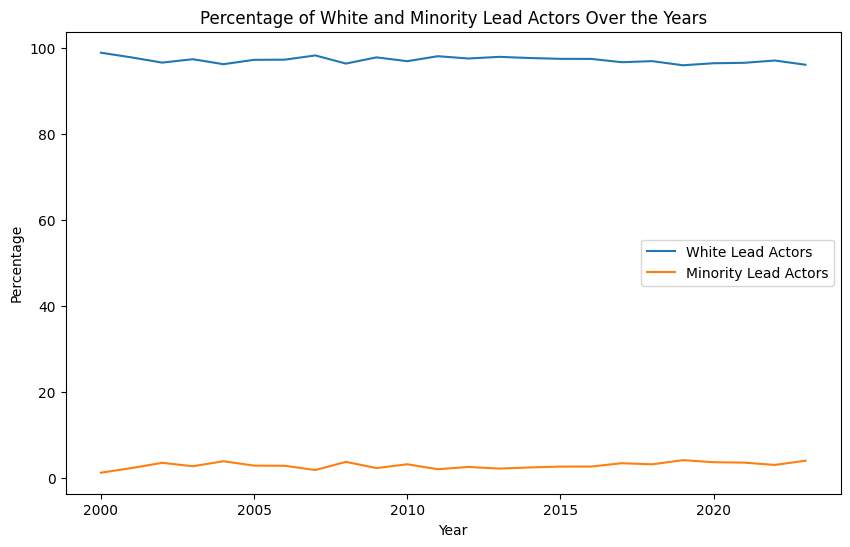

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Example function for getting ethnicity scores (replace with your actual function)
def get_ethnicity_scores(actor):
    # Your implementation here
    # print(actor)

    return namesDict[actor]

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Data\Final\output_movies_data_0-35k_by_year_2000+.csv')

# Calculate the percentage of white lead actors and minority actors for each year
# print(df['actors'])
# convert df['actors'] to a list of strings
df['actors'] = df['actors'].apply(lambda x: ast.literal_eval(x))

# print(df['actors'])
# string_list = ast.literal_eval(row["actors"])

# actors = [x.strip() for x in string_list]


df['White'] = df['actors'].apply(lambda actors: max((get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors))
df['Minority'] = 1 - df['White']

# Group by year and calculate the mean percentage for each group
grouped_data = df.groupby('year').mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['White'] * 100, label='White Lead Actors')
plt.plot(grouped_data.index, grouped_data['Minority'] * 100, label='Minority Lead Actors')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of White and Minority Lead Actors Over the Years')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [6]:
import pandas as pd
import numpy as np
import ast



# Example function for getting ethnicity scores (replace with your actual function)
def get_ethnicity_scores(actor):
    # Your implementation here
    # Assuming namesDict is a dictionary containing actors' ethnicity scores
    return namesDict[actor]

# Load your data
df = pd.read_csv('Merged_diversity_movies.csv')

# Ensure the actors column is a list of strings (if necessary)
df['actors'] = df['actors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Calculate the percentage of white lead actors and minority actors for each year
# Here, make sure the calculation reflects the correct percentages
# This part of the code may need to be adjusted based on your actual function and what it returns

# Whites should be 1 if majortiyy (>3) actors have 1 in the last index of the tuple
df
# df['White'] = df['actors'].apply(lambda actors: ((get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))
# df['Minority'] = df['actors'].apply(lambda actors: (1-(get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))


# Normalize the counts to get percentages if necessary
# This will depend on what `get_ethnicity_scores` returns
df['White'] = df['White'] / df['actors'].apply(len)
df['Minority'] = df['Minority'] / df['actors'].apply(len)

# Group by year and calculate the mean percentage for each group
grouped_data = df.groupby('year').mean()

# Plot the data with markers for each percentage point
plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['White'] * 100, marker='o', label='White Lead Actors')
plt.plot(grouped_data.index, grouped_data['Minority'] * 100, marker='o', label='Minority Lead Actors')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of White and Minority Lead Actors Over the Years')

# Add a legend
plt.legend()

# Show the plot with gridlines for better readability
plt.grid(True)
plt.show()


TypeError: unsupported operand type(s) for /: 'generator' and 'int'

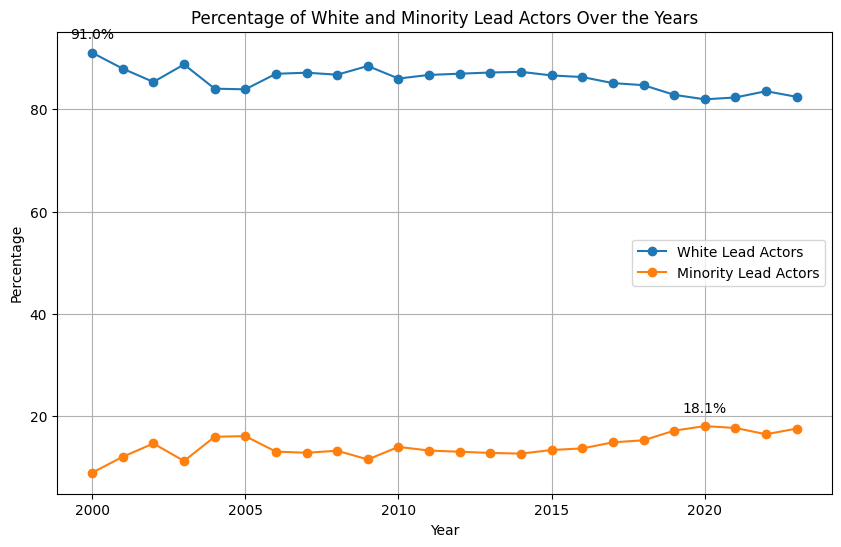

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Example function for getting ethnicity scores (replace with your actual function)
def get_ethnicity_scores(actor):
    # Your implementation here
    # Assuming namesDict is a dictionary containing actors' ethnicity scores
    return namesDict[actor]

# Load your data
df = pd.read_csv('Data/Final/output_movies_data_0-35k_by_year_2000+.csv')

# Ensure the actors column is a list of strings (if necessary)
df['actors'] = df['actors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Calculate the percentage of white lead actors and minority actors for each year
# Here, make sure the calculation reflects the correct percentages
# This part of the code may need to be adjusted based on your actual function and what it returns
df['White'] = df['actors'].apply(lambda actors: sum((get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))
df['Minority'] = df['actors'].apply(lambda actors: sum(1-(get_ethnicity_scores(actor)[-1] if namesDict[actor]!= () else 0) for actor in actors if actor in namesDict))

# Normalize the counts to get percentages if necessary
# This will depend on what `get_ethnicity_scores` returns
df['White'] = df['White'] / df['actors'].apply(len)
df['Minority'] = df['Minority'] / df['actors'].apply(len)

# Group by year and calculate the mean percentage for each group
grouped_data = df.groupby('year').mean()

# Plot the data with markers for each percentage point
plt.figure(figsize=(10, 6))
white_line, = plt.plot(grouped_data.index, grouped_data['White'] * 100, marker='o', label='White Lead Actors')
minority_line, = plt.plot(grouped_data.index, grouped_data['Minority'] * 100, marker='o', label='Minority Lead Actors')


# Find the max value for white lead actors and minority lead actors
max_white = grouped_data['White'].max()
max_minority = grouped_data['Minority'].max()

# Get the year for the max values
max_white_year = grouped_data['White'].idxmax()
max_minority_year = grouped_data['Minority'].idxmax()

# Annotate the highest point for white lead actors
plt.annotate(f'{max_white * 100:.1f}%', (max_white_year, max_white * 100),
             textcoords="offset points", xytext=(0,10), ha='center')

# Annotate the highest point for minority lead actors
plt.annotate(f'{max_minority * 100:.1f}%', (max_minority_year, max_minority * 100),
             textcoords="offset points", xytext=(0,10), ha='center')


# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of White and Minority Lead Actors Over the Years')

# Add a legend
plt.legend()

# Show the plot with gridlines for better readability
plt.grid(True)
plt.show()


In [8]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Assuming your data is in a CSV file named 'movie_data.csv'
# Replace 'movie_data.csv' with the actual name of your file
df = pd.read_csv('Data/Final/output_movies_data_0-35k_by_year_2000+.csv')

# Verify the column names in your dataset
print(df.columns)

# Extracting relevant columns
X = df[['tomatometer', 'audience_score', 'weighted_score', 'year']]
y = df['diversity_score']

# Adding a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

ModuleNotFoundError: No module named 'statsmodels'

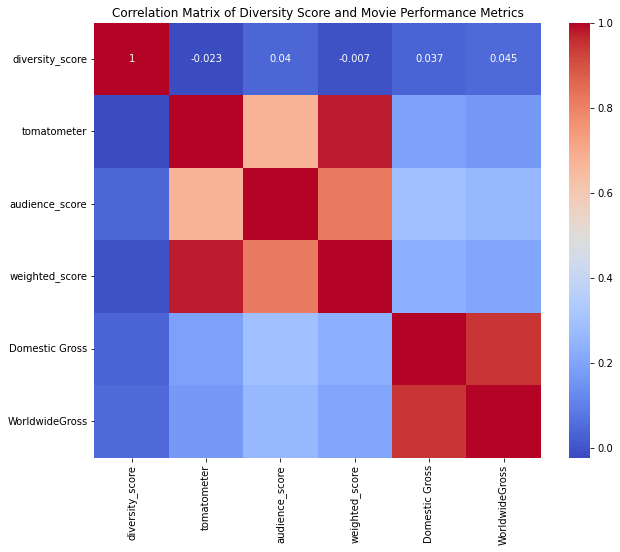

(                 diversity_score  Profitability
 diversity_score         1.000000       0.034476
 Profitability           0.034476       1.000000,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:          Profitability   R-squared:                       0.001
 Model:                            OLS   Adj. R-squared:                  0.001
 Method:                 Least Squares   F-statistic:                     2.761
 Date:                Tue, 21 Nov 2023   Prob (F-statistic):             0.0967
 Time:                        16:38:01   Log-Likelihood:                -47484.
 No. Observations:                2322   AIC:                         9.497e+04
 Df Residuals:                    2320   BIC:                         9.498e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
  

In [21]:
# Findings

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

file_path = 'Merged_diversity_movies.csv'
movies_data = pd.read_csv(file_path)


# Convert 'WorldwideGross' and 'Domestic Gross' to numeric after removing currency symbols and commas
movies_data['WorldwideGross'] = movies_data['WorldwideGross'].replace('[\$,]', '', regex=True).astype(float)
movies_data['Domestic Gross'] = movies_data['Domestic Gross'].replace('[\$,]', '', regex=True).astype(float)

# Correlation analysis
correlation_matrix = movies_data[['diversity_score', 'tomatometer', 'audience_score', 'weighted_score', 'Domestic Gross', 'WorldwideGross']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Diversity Score and Movie Performance Metrics')
plt.show()


# Preparing data for regression analysis
# Independent variable: diversity_score
# Dependent variables: tomatometer, audience_score, weighted_score, Domestic Gross, WorldwideGross
X = movies_data['diversity_score']
y_vars = ['tomatometer', 'audience_score', 'weighted_score', 'Domestic Gross', 'WorldwideGross']

# Performing regression analysis for each dependent variable and collecting p-values
regression_results = {}

for y_var in y_vars:
    y = movies_data[y_var].dropna()
    X_subset = X[y.index]  # Ensuring the X and y have the same length after dropping NaNs in y

    # Adding a constant term to the predictor (linear regression model assumes y = mx + c)
    X_with_const = sm.add_constant(X_subset)

    # Fitting the regression model
    model = sm.OLS(y, X_with_const).fit()

    # Collecting the p-value of the diversity_score coefficient
    p_value = model.pvalues['diversity_score']
    regression_results[y_var] = p_value

regression_results


# Filtering out movies with missing financial data
financial_data = movies_data[['diversity_score', 'Production Budget', 'Domestic Gross', 'WorldwideGross']].dropna()

# Converting 'Production Budget' to numeric
financial_data['Production Budget'] = financial_data['Production Budget'].replace('[\$,]', '', regex=True).astype(float)

# Calculating profitability (Worldwide Gross - Production Budget)
financial_data['Profitability'] = financial_data['WorldwideGross'] - financial_data['Production Budget']

# Correlation between diversity score and profitability
correlation_profitability = financial_data[['diversity_score', 'Profitability']].corr()

# Regression analysis for diversity score and profitability
X_profit = financial_data['diversity_score']
y_profit = financial_data['Profitability']

# Adding a constant term to the predictor
X_profit_const = sm.add_constant(X_profit)

# Fitting the regression model
model_profit = sm.OLS(y_profit, X_profit_const).fit()

# Results
correlation_profitability, model_profit.summary()
